## Paddy Kaggle Notebook (Pytorch ported to FastAI)

In [1]:
import torch
import pandas as pd
import torch.optim as optim
import sklearn
from sklearn.model_selection import train_test_split
sklearn.__version__

# autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import setup_env as su
su.setup_env()

import paddy_funcs_classes as pfc

Script already ran...bailing


## CFG file

In [3]:
CFG=pfc.PROJECT_CFG()

### Get data

In [4]:
df =pd.read_csv(CFG.csv_path)
# df.head()

#EXPERIMENT ON SUBSET OF DATA?
if CFG.subsample_data:
    #stratify dataframe by multiple columns (see Paddy-Multi.ipynb)
    # df, _ = train_test_split(df, test_size=0.5, random_state=0, stratify=df[['label', 'variety']])

    #get a small dataset to train on
    df=df.iloc[:500,:]

    print(df.shape)

### Get list of transforms that the original model used (mean, std)

In [5]:
# import timm
# cfg=timm.data.resolve_data_config({}, model=CFG.model_name, verbose=True)
# cfg

## Put custom model in FastAI

In [6]:
import fastai
import fastai.tabular.data
from torch.utils.data import Dataset
from fastai.vision.all import *
set_seed(42)
path =Path('./data/')

## The below dataloader returns image and label

In [7]:
# #create a dict to map label strings to tensors
# i_to_label=dict(enumerate(df.label.unique()))
# label_to_i={v:i for i,v in i_to_label.items()}
# # print(i_to_label)
# # print(label_to_i)

# #create another to map variety strings to tensors
# i_to_variety=dict(enumerate(df.variety.unique()))
# variety_to_i={v:i for i,v in i_to_variety.items()}

In [7]:
#creae a dict that maps from image_id to variety
img_id=df.image_id
variety=df.variety

itov=dict(zip(img_id,variety))
def getvariety(p): return itov[p.name]  

In [8]:
#thisdatablock ensures that image, label and variety are returned
dblock=DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),   #ImageBlock works if passed a path to image, CategoryBlock works if passed a string to categorify to an int
                 n_inp=1,   #imageblock
                 get_items=get_image_files,
                 get_y=[parent_label,getvariety],  #2 cat blocks ricetype and disease variety type
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=Resize(192,method='squish'),
                 batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls=dblock.dataloaders(CFG.train_path)
# dls.show_batch()

In [16]:
def dtc_loss(preds,y_label,y_variety):
    rice_preds, variety_preds=preds
    c_loss = nn.CrossEntropyLoss()
    return c_loss(rice_preds,y_label)+c_loss(variety_preds,y_variety)

def dtc_error(preds,y_label,y_variety):
    rice_preds, variety_preds=preds
    return error_rate(rice_preds,y_label)+error_rate(variety_preds,y_variety)

def acc_labels(preds,y_label,y_variety):
    '''
    preds:[nxn] tensor
    lbls:[1xn] tensor
    sums number of lbl positions that are equivalent to max pred
    then divides by total number of samples
    returns: float between 0 and 1
    '''
    label_preds, variety_preds=preds
    return ((torch.argmax(label_preds,dim=1)==y_label).sum()/len(y_label)).item()

def acc_variety(preds,y_label,y_variety):
    '''
    preds:[nxn] tensor
    lbls:[1xn] tensor
    sums number of lbl positions that are equivalent to max pred
    then divides by total number of samples
    returns: float between 0 and 1
    '''
    label_preds, variety_preds=preds
    return ((torch.argmax(variety_preds,dim=1)==y_variety).sum()/len(y_variety)).item()

In [17]:
from fastai.vision.all import *
import timm

#create the timm model
tmodel=timm.create_model('resnet26d', pretrained=True, num_classes=CFG.num_classes_in_output_layer,global_pool='catavgmax') 

#and pass it to DiseaseAndTypeClassifier
m1=pfc.DiseaseAndTypeClassifier(tmodel)

learn = Learner(dls, model=m1, loss_func=dtc_loss, metrics=[acc_labels,acc_variety ])

# learn.loss_func

CPU times: user 12.3 s, sys: 5.11 s, total: 17.4 s
Wall time: 19.5 s


SuggestedLRs(valley=7.585775892948732e-05, slide=0.05754399299621582)

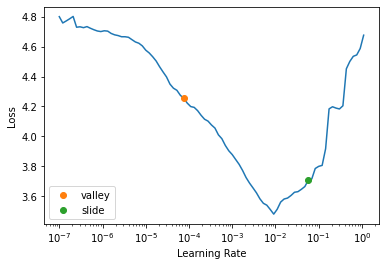

In [11]:
%%time
learn.lr_find(suggest_funcs=(valley,slide))

In [18]:
%%time
learn.fine_tune(CFG.N_EPOCHS,base_lr=0.003)

epoch,train_loss,valid_loss,acc_labels,acc_variety,time
0,1.859761,3.933093,0.465161,0.756848,00:28


epoch,train_loss,valid_loss,acc_labels,acc_variety,time
0,0.651991,0.614765,0.853916,0.954349,00:28
1,0.736334,1.049291,0.759250,0.888996,00:28
2,0.678575,1.084316,0.763575,0.900048,00:28
3,0.554074,1.184004,0.755887,0.922153,00:29
4,0.385851,0.756614,0.839981,0.899087,00:29
5,0.287343,0.386754,0.918789,0.966843,00:29
6,0.171980,0.237733,0.954349,0.974531,00:29
7,0.100684,0.202420,0.956752,0.987025,00:29
8,0.061556,0.156082,0.968284,0.990870,00:29
9,0.045792,0.160536,0.966362,0.990389,00:29


CPU times: user 3min 3s, sys: 1min 15s, total: 4min 19s
Wall time: 5min 20s


## Generate submission

In [19]:
pfc.generate_submission(learn.model,df)

## Zip And Upload to Kaggle


In [20]:
!zip ./submission.zip ./submission.csv
!kaggle competitions submit -c paddy-disease-classification -f submission.zip -m "Message"

  adding: submission.csv (deflated 85%)
100%|██████████████████████████████████████| 9.93k/9.93k [00:00<00:00, 17.2kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification